#*3. XGB Model을 통한 매출예측*

## 0. Library import

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

## 1. Data Loading

In [24]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
train = pd.read_csv("/content/drive/MyDrive/train_r.csv")
test = pd.read_csv('/content/drive/MyDrive/test_r.csv')
store = pd.read_csv('/content/drive/MyDrive/store_r.csv')

<ipython-input-25-541297a00893>:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("/content/drive/MyDrive/train_r.csv")


In [26]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [27]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [28]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# Train / Test 컬럼 정보
- id
- Store: 각 상점의 id
- Date: 날짜
- Sales: 날짜에 따른 매출
- Promo: 판매촉진 행사 진행 여부
- StateHoliday: 공휴일 여부/ 공휴일 X-> 0, 공휴일-> 공휴일의 종류(a, b, c)
- SchoolHoliday: 학교 휴일인지 여부

# Store 컬럼 정보
- Store: 매장 번호
- StoreType: 매장 유형
- Assortment: 상품 구성
- CompetitionDistance: 경쟁 매장과의 거리
- CompetitionOpenSinceMonth: 경쟁 매장이 오픈한 월
- CompetitionOpenSinceYear: 경쟁 매장이 오픈한 년도
- Promo2: 프로모션 2 여부
- Promo2SinceWeek: 프로모션 2 시작 주
- Promo2SinceYear: 프로모션 2 시작 년도
- PromoInterval: 프로모션 간격

#*위의 컬럼들을 사용하여 Sales(매출) 을 예측하는 모델을 생성*

- 분석 절차 수립
1. 베이스 모델링 ( feature engineering - 변수선택 - 모델링 )

2. 2차 모델링 ( store 데이터 merge - feature engineering - 변수 선택 - 모델링 )

3. 파라미터 튜닝

4. 모델링 반복

## 2. 베이스 모델링
- 가장 기본적인 모델을 만듬. 데이터전처리 등 (결측값 처리, 원핫 인코딩)

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [30]:
#결측값은 없는 것을 알 수 있고, object 타입인 Date, StateHoliday 컬럼을 전처리
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

# 'Date' 컬럼의 데이터 형식을 변경:
# 원래 'Date' 컬럼은 object 데이터 형식으로 되어 있었으며,
# 날짜와 관련된 연산을 수행하기 위해서는 날짜 데이터 형식으로 변환해야 함.
# 따라서 pd.to_datetime() 함수를 사용하여 'Date' 컬럼의 값을 날짜 형식으로 변환함.

# 데이터 분석 및 모델링:
# 날짜 데이터는 시계열 데이터의 중요한 부분이며,
# 날짜와 관련된 특징을 활용하여 데이터 분석 및 모델링을 수행할 때 중요한 역할을 함.
# 이러한 이유로 'Date' 컬럼을 날짜 데이터 형식으로 변환하는 것이 필요함.

# 시계열 데이터 다루기:
# 시계열 데이터는 시간에 따른 변화를 분석하고 예측하기 위해 특별한 기술과 모델을 필요로 함.
# 날짜 데이터를 날짜 형식으로 변환하면 시계열 데이터를 더 쉽게 다룰 수 있음.

# 코드 1은 'Date' 컬럼을 날짜 형식으로 변환하여 데이터를 더 효과적으로 다루고 시계열 데이터 분석 및 모델링에 활용하기 위한 중요한 단계

In [31]:
# get_dummies 함수를 사용하여 StateHoliday 컬럼을 원핫인코딩
print("train_columns: ", train.columns, end="\n\n\n")
print("test_columns: ", test.columns)

# train_columns:과 test_columns:는 출력될 메시지입니다.
# 이 메시지를 통해 출력 결과가 어떤 데이터프레임의 컬럼 이름인지 알 수 있게 됩니다.

# train.columns과 test.columns는 각각 train과 test 데이터프레임의 컬럼 이름을 가져오는 코드.

# end="\n\n\n"은 출력 결과의 마지막에 빈 줄을 세 개 추가하도록 지정하는 부분입니다.
# 따라서 출력 결과가 보기 좋게 각각의 데이터프레임 컬럼 이름을 출력하고 빈 줄을 세 개 추가하여 시각적으로 구분할 수 있게 됨.

# 이 코드는 데이터프레임의 컬럼 구조를 파악하고 데이터의 특성을 이해하는 데 도움을 주며, 어떤 컬럼이 있는지 확인할 때 유용.
# 데이터의 구조와 특성을 이해하는 것은 데이터 분석과 모델링을 수행할 때 중요한 첫 단계 중 하나

train_columns:  Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')


test_columns:  Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday'],
      dtype='object')


In [32]:
# StateHoliday column one-hot encoding
train = pd.get_dummies(columns=['StateHoliday'], data=train, drop_first=True)
# StateHoliday column one-hot encoding for test data
test = pd.get_dummies(columns=['StateHoliday'], data=test, drop_first=True)


# 위 코드는 train 데이터프레임의 'StateHoliday' 컬럼을 원핫 인코딩하는 부분입니다.
# pd.get_dummies()
# - 함수를 사용하여 'StateHoliday' 컬럼을 원핫 인코딩. 이는 범주형 데이터를 숫자로 변환하는 방법 중 하나로, 각 카테고리 값을 새로운 이진 열(0 또는 1)로 변환함.
# columns=['StateHoliday']
# - 매개변수는 어떤 컬럼을 원핫 인코딩할지 지정. 여기서는 'StateHoliday' 컬럼을 대상.
# data=train 매개변수
# - 어떤 데이터프레임에서 변환을 수행할 것인지 지정합니다. 여기서는 train 데이터프레임을 대상.
# drop_first=True
# - 매개변수는 첫 번째 카테고리 값을 제거하여 다중공선성 문제를 방지.
# - 첫 번째 카테고리의 존재 여부는 나머지 카테고리에서 이미 알 수 있기 때문.

# 마찬가지로 pd.get_dummies() 함수를 사용
# - 'StateHoliday' 컬럼을 원핫 인코딩.
# 이렇게 하면 'StateHoliday' 컬럼의 범주형 정보를 이진 열로 변환하여 머신러닝 모델에 입력할 수 있음.

In [33]:
# 'StateHoliday_b'와 'StateHoliday_c' 열의 모든 행에 0이라는 값을 할당

test['StateHoliday_b'] = 0
test['StateHoliday_c'] = 0

In [34]:
train['Date']

0         2015-07-31
1         2015-07-31
2         2015-07-31
3         2015-07-31
4         2015-07-31
             ...    
1017204   2013-01-01
1017205   2013-01-01
1017206   2013-01-01
1017207   2013-01-01
1017208   2013-01-01
Name: Date, Length: 1017209, dtype: datetime64[ns]

In [35]:
# 'Date' 컬럼의 값을 날짜 데이터 형식으로 변환
train['Date'] = pd.to_datetime( train['Date'] )
test['Date'] = pd.to_datetime( test['Date'] )

In [36]:
# 요일 컬럼 weekday 생성
train['weekday'] = train['Date'].dt.weekday
test['weekday'] = test['Date'].dt.weekday

# 년도 컬럼 year 생성
train['year'] = train['Date'].dt.year
test['year'] = test['Date'].dt.year

# 월 컬럼 month 생성
train['month'] = train['Date'].dt.month
test['month'] = test['Date'].dt.month

In [38]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   Store           1017209 non-null  int64         
 1   DayOfWeek       1017209 non-null  int64         
 2   Date            1017209 non-null  datetime64[ns]
 3   Sales           1017209 non-null  int64         
 4   Customers       1017209 non-null  int64         
 5   Open            1017209 non-null  int64         
 6   Promo           1017209 non-null  int64         
 7   SchoolHoliday   1017209 non-null  int64         
 8   StateHoliday_0  1017209 non-null  uint8         
 9   StateHoliday_a  1017209 non-null  uint8         
 10  StateHoliday_b  1017209 non-null  uint8         
 11  StateHoliday_c  1017209 non-null  uint8         
 12  weekday         1017209 non-null  int64         
 13  year            1017209 non-null  int64         
 14  month           10

In [40]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Id              41088 non-null  int64         
 1   Store           41088 non-null  int64         
 2   DayOfWeek       41088 non-null  int64         
 3   Date            41088 non-null  datetime64[ns]
 4   Open            41077 non-null  float64       
 5   Promo           41088 non-null  int64         
 6   SchoolHoliday   41088 non-null  int64         
 7   StateHoliday_a  41088 non-null  uint8         
 8   StateHoliday_b  41088 non-null  int64         
 9   StateHoliday_c  41088 non-null  int64         
 10  weekday         41088 non-null  int64         
 11  year            41088 non-null  int64         
 12  month           41088 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(10), uint8(1)
memory usage: 3.8 MB


2-1. 베이스라인 모델링

In [41]:
from xgboost import XGBRegressor

In [42]:
train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b',
       'StateHoliday_c', 'weekday', 'year', 'month'],
      dtype='object')

In [43]:
xgb = XGBRegressor( n_estimators= 300 , learning_rate=0.1 , random_state=2020 ) # n_estimotors= 트리갯수, learning rate = 학습률(가중치), random_state = 모델의 무작위성을 제어, 모델의 재현성을 보장
xgb.fit(train[['Promo','SchoolHoliday','StateHoliday_0','StateHoliday_a','StateHoliday_b','StateHoliday_c','weekday','year','month']], # Features
        train['Sales']) # Y_label

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=2020, ...)

#xgb = XGBRegressor( n_estimators= 300 , learning_rate=0.1 , random_state=2020 )의 해석

### 1. n_estimators:

- XGBoost 모델에서 사용되는 트리의 개수
- 이 값은 모델이 학습하는 트리의 개수를 지정
- 많은 트리를 사용할수록 모델의 복잡도가 증가하고 더 나은 성능을 얻을 수 있지만, 계산 비용이 증가하고 과적합의 위험
- 일반적으로 적절한 값을 찾기 위해 교차 검증(Cross Validation)을 사용하거나 그리드 서치(Grid Search)를 수행
- 예제에서는 n_estimators를 300으로 설정하였으므로, 모델은 300개의 트리를 사용하여 훈련됩니다.

### 2. learning_rate:

- learning_rate는 각 트리의 예측 결과에 대한 가중치(학습률)를 나타냄.
- 이 값은 각 트리의 예측 결과를 얼마나 반영할지를 조절하는 역할
- 작은 값일수록 각 트리의 기여가 작아지며 모델이 더 안정적으로 수렴하지만, 너무 작으면 모델이 수렴하는데 시간이 오래 걸릴 수 있음.
- 일반적으로 learning_rate를 조정하면서 최적의 값을 찾음.
 - 보통 0.01부터 0.3 정도의 범위에서 설정. 높은 값은 과적합의 위험이 있습니다.
 - 해당 train은 learning_rate를 0.1로 설정

### 3. random_state:
- random_state는 랜덤 시드(Random Seed)로, 모델의 무작위성을 제어하는 데 사용
- 모델 내부에서 무작위성을 사용하는 경우, 동일한 랜덤 시드를 설정하면 항상 동일한 결과를 얻을 수 있음.
- 이는 모델의 재현성을 보장하기 위한 것입니다.
 - random_state를 특정 숫자(예: 2020)로 설정하면 항상 동일한 무작위성을 갖는 모델을 얻을 수 있음.
 - 그렇지 않으면 모델이 실행할 때마다 다른 결과를 얻을 수 있음.

# 교차검증

#### 교차검증(cross_validation)의 목적
- 모델의 성능을 신뢰성 있게 평가하고 일반화 성능을 추정하기 위한 기법
- 주어진 데이터를 여러 번 나누어 학습과 평가를 반복하며 모델의 성능을 평가, 일반화 능력을 평가

In [18]:
from sklearn.model_selection import cross_val_score
cross_val_score(xgb, train[['Promo', 'weekday', 'month','year', 'SchoolHoliday']], train['Sales'], scoring="neg_mean_squared_error", cv=3)
#scoring="neg_mean_squared_error"
#"neg_" 접두사는 MSE의 음수값을 반환하도록 지정한 것으로, 값이 작을수록 모델의 성능이 더 좋다는 관례에 따른 것

array([-8352303.26810886, -8242562.69572846, -7761767.97637666])

In [ ]:
test[['id','Sales']].to_csv("submission.csv",index=False)

In [44]:
xgb.feature_importances_

array([0.08092494, 0.00242644, 0.00303826, 0.37883526, 0.18911253,
       0.1639084 , 0.17197496, 0.00220009, 0.00757915], dtype=float32)

- 모든 컬럼을 사용했을 때 보다 오류율이 감소
- 그렇다면 컬럼을 몇개 사용하는 것이 가장 오류율을 줄게 하는지 추가훈련 필요

In [45]:
input_var = ['Promo','SchoolHoliday','StateHoliday_0','StateHoliday_a','StateHoliday_b','StateHoliday_c','weekday','year','month']

- input_var: 분석에서 사용한 독립 변수(특성)들의 리스트를 생성

In [46]:
imp_df = pd.DataFrame({"var": input_var,
                       "imp": xgb.feature_importances_})

- 각 독립 변수(특성)의 중요도(importance)를 저장하기 위한 데이터프레임을 생성
- xgb.feature_importances_: XGBoost 모델에서 학습된 각 특성의 중요도를 나타내는 속성. 이 값은 모델이 예측을 수행하는 데 어떤 특성이 얼마나 중요한지를 나타냄.

In [47]:
imp_df = imp_df.sort_values(['imp'],ascending=False)
imp_df

,var,imp
3,StateHoliday_a,0.378835
4,StateHoliday_b,0.189113
6,weekday,0.171975
5,StateHoliday_c,0.163908
0,Promo,0.080925
8,month,0.007579
2,StateHoliday_0,0.003038
1,SchoolHoliday,0.002426
7,year,0.002200


##### 결과해석
- 'StateHoliday_a'가 가장 높은 중요도(0.378835)를 가지며, 모델 예측에 가장 큰 영향을 미침.
- 'StateHoliday_b', 'weekday', 'StateHoliday_c' 등도 중요한 특성으로 나타나며, 'year'와 'SchoolHoliday'가 가장 낮은 중요도

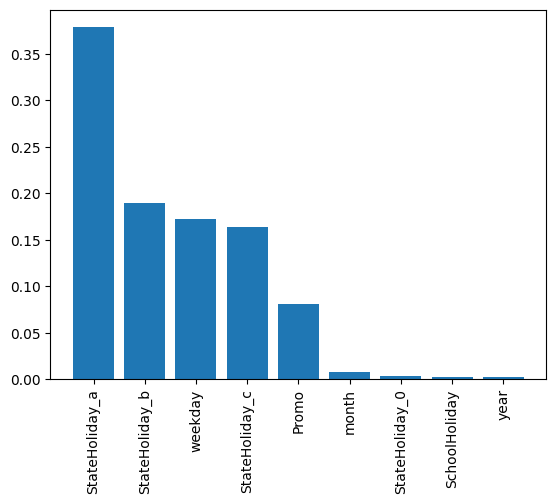

In [48]:
#특성중요도 시각화

import matplotlib.pyplot as plt
plt.bar(imp_df['var'],imp_df['imp'])
plt.xticks(rotation=90)
plt.show()

In [49]:
cross_val_score(xgb, train[['Promo', 'weekday', 'month','year', 'SchoolHoliday']], train['Sales'], scoring="neg_mean_squared_error", cv=3)

array([-8352303.26810886, -8242562.69572846, -7761767.97637666])

- 해당 XGBoost 모델은 교차 검증을 통해 나온 평균 음수 MSE 값이 비교적 작으므로, 주어진 특성을 기반으로
*매출(Sales)을 예측하는 데 상당히 좋은 성능*

In [50]:
import numpy as np
score_list=[] # 여러 변수 조합을 테스트하고 각 조합의 평균 음수 평균 제곱 오차(MSE) 값을 저장할 리스트
selected_varnum=[] # 각 변수 조합에 대한 변수 개수를 저장할 리스트

In [51]:
for i in range(1,10):
    selected_var = imp_df['var'].iloc[:i].to_list() # imp_df에서 중요도가 가장 높은 변수부터 i개를 선택하여 selected_var 리스트에 저장
    scores = cross_val_score(xgb,
                             train[selected_var],
                             train['Sales'],
                             scoring="neg_mean_squared_error", cv=3)
    # cross_val_score 함수를 사용하여 선택한 변수 조합을 기반으로 XGBoost 모델을 교차 검증하여 평균 음수 MSE 값을 계산. 음수 MSE 값은 양수로 변환되고, 이 값들을 score_list에 추가
    # 현재까지 선택한 변수 개수(i)를 selected_varnum에 추가
    # 각 변수 개수(i)에 대해 반복문이 실행되며, 선택한 변수 조합에 대한 평균 음수 MSE 값을 출력
    score_list.append(-np.mean(scores))
    selected_varnum.append(i)
    print(i)

1
2
3
4
5
6
7
8
9


- 변수 개수를 1부터 9까지 시도하여 어떤 변수 조합이 모델의 성능을 최적화하는지를 평가.
- 결과는 변수 개수(i)에 따른 음수 MSE 값들이 score_list에 저장됨.
- 이를 통해 가장 적절한 변수 개수나 변수 조합을 선택하고 모델을 튜닝하는 데 도움을 줄 수 있음.
- 예를 들어, selected_varnum과 score_list를 시각화하여 변수 개수에 따른 모델 성능의 추이를 확인할 수 있음. 최적의 변수 개수를 선택하고 모델을 개선하는 데 활용

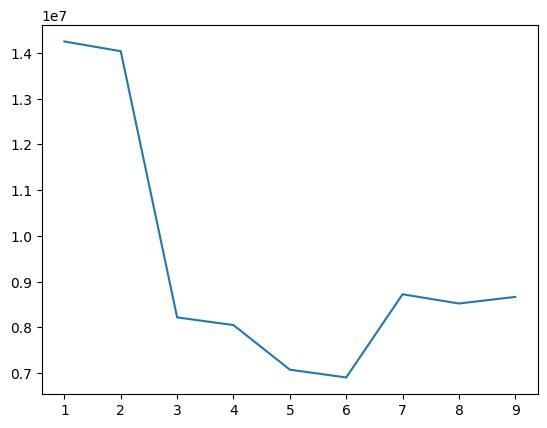

In [52]:
plt.plot(selected_varnum, score_list)

 - 변수의 개수 별로 cross validation을 수행한 결과 2개일 때 가장 낮은 것을 볼 수 있음
 - 예측변수가 2개일 때 cross validation을 수행한다

### 개선 : 예측변수 2개일때로 Cross Validation 수행

In [82]:
cross_val_score(xgb, train[['Promo', 'weekday']], train['Sales'], scoring="neg_mean_squared_error", cv=2)

array([-8521126.29143028, -7939894.6072351 ])

- 두번째 빼고는 모두 줄어듬.
- cross_val_score(xgb, train[['Promo', 'weekday', 'month','year', 'SchoolHoliday']], train['Sales'], scoring="neg_mean_squared_error", cv=3)
- Output : ( array([-8352303.26810886, -8242562.69572846, -7761767.97637666]) )

- cross_val_score(xgb, train[['Promo', 'weekday']], train['Sales'], scoring="neg_mean_squared_error", cv=3)
- Output : ( array([-8667454.60887395, -8469190.35192911, -7543481.54172072]) )

# 2 . Store Data Merging Process

In [54]:
# Store.csv 파일 확인
store

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [55]:
train = pd.merge(train, store, on=['Store'], how='left') # store의 데이터값들을 train 데이터의 우측에 추가
test = pd.merge(test, store, on=['Store'], how='left')  # store의 데이터값들을 test 데이터의 우측에 추가

In [56]:
# CompetitionOpen = 12 * (현재 연도 - 경쟁 업체 개점 연도) + (현재 월 - 경쟁 업체 개점 월)

train['CompetitionOpen'] = 12*( train['year'] - train['CompetitionOpenSinceYear'] ) + \
                             (train['month'] - train['CompetitionOpenSinceMonth'])

test['CompetitionOpen'] = 12*( test['year'] - test['CompetitionOpenSinceYear'] ) + \
                             (test['month'] - test['CompetitionOpenSinceMonth'])

# 각 데이터 포인트(매장)에 대해 경쟁 업체가 개점한 이후의 경과 시간을 새로운 열로 저장할 수 있음.
# 이 정보는 모델 학습 및 예측에 활용될 수 있으며, 경쟁 업체의 개점 이후 시간이 매출에 미치는 영향을 분석하는 데 사용

In [57]:
train['WeekOfYear'] = train['Date'].dt.weekofyear # 현재 날짜가 몇번째 주인지
test['WeekOfYear'] = test['Date'].dt.weekofyear # 현재 날짜가 몇번째 주인지

<ipython-input-57-23123be664fc>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train['WeekOfYear'] = train['Date'].dt.weekofyear # 현재 날짜가 몇번째 주인지
<ipython-input-57-23123be664fc>:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  test['WeekOfYear'] = test['Date'].dt.weekofyear


In [58]:
# PromoOpen = 12 * (현재 연도 - 프로모션 시작 연도) + (현재 주 - 프로모션 시작 주) / 4

train['PromoOpen'] = 12* ( train['year'] - train['Promo2SinceYear'] ) + \
                        (train['WeekOfYear'] - train['Promo2SinceWeek']) / 4

test['PromoOpen'] = 12* ( test['year'] - test['Promo2SinceYear'] ) + \
                        (test['WeekOfYear'] - test['Promo2SinceWeek']) / 4

# 프로모션 효과와 관련된 데이터 분석 및 예측에 활용

In [59]:
train.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
SchoolHoliday                         int64
StateHoliday_0                        uint8
StateHoliday_a                        uint8
StateHoliday_b                        uint8
StateHoliday_c                        uint8
weekday                               int64
year                                  int64
month                                 int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                 

## 1. One-Hot Encoding 진행

In [60]:
# 매장의 유형을 나타내는 범주형 변수. 이 열을 원핫 인코딩하여 각 유형을 나타내는 이진 열을 생성
train = pd.get_dummies(columns=['StoreType'],data=train)
test = pd.get_dummies(columns=['StoreType'],data=test)

In [61]:
# 매장의 상품 분류 유형을 나타내는 범주형 변수. 이 열을 원핫 인코딩하여 각 분류 유형을 나타내는 이진 열을 생성
train = pd.get_dummies(columns=['Assortment'],data=train)
test = pd.get_dummies(columns=['Assortment'],data=test)

In [62]:
# 프로모션의 활성화 월을 나타내는 범주형 변수. 이 열을 원핫 인코딩하여 각 월을 나타내는 이진 열을 생성
train = pd.get_dummies(columns=['PromoInterval'],data=train)
test = pd.get_dummies(columns=['PromoInterval'],data=test)

In [63]:
train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b',
       'StateHoliday_c', 'weekday', 'year', 'month', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'CompetitionOpen', 'WeekOfYear',
       'PromoOpen', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
       'Assortment_a', 'Assortment_b', 'Assortment_c',
       'PromoInterval_Feb,May,Aug,Nov', 'PromoInterval_Jan,Apr,Jul,Oct',
       'PromoInterval_Mar,Jun,Sept,Dec'],
      dtype='object')

In [64]:
test.columns

Index(['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'SchoolHoliday',
       'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'weekday', 'year',
       'month', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'CompetitionOpen', 'WeekOfYear', 'PromoOpen',
       'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
       'Assortment_a', 'Assortment_b', 'Assortment_c',
       'PromoInterval_Feb,May,Aug,Nov', 'PromoInterval_Jan,Apr,Jul,Oct',
       'PromoInterval_Mar,Jun,Sept,Dec'],
      dtype='object')

In [65]:
input_var = ['Promo', 'SchoolHoliday',
       'StateHoliday_0', 'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c',
       'weekday', 'year', 'month', 'CompetitionDistance',
       'Promo2',
       'CompetitionOpen', 'WeekOfYear',
       'PromoOpen', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
       'Assortment_a', 'Assortment_b', 'Assortment_c',
       'PromoInterval_Feb,May,Aug,Nov', 'PromoInterval_Jan,Apr,Jul,Oct',
       'PromoInterval_Mar,Jun,Sept,Dec']

In [66]:
# 'set(train) - set(input_var)' ->  train 데이터프레임의 열 중에서 input_var에 포함되지 않은 열의 집합
set(train) - set(input_var)

{'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Customers',
 'Date',
 'DayOfWeek',
 'Open',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'Sales',
 'Store'}

In [67]:
xgb = XGBRegressor( n_estimators=300, learning_rate= 0.1, random_state=2020)
xgb.fit(train[input_var],train['Sales'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=2020, ...)

In [68]:
cross_val_score(xgb, train[input_var], train['Sales'], scoring="neg_mean_squared_error", cv=3)

array([-3521021.46935192, -8237737.45907591, -2913406.83818824])

### 교차 검증을 통해 얻은 MSE 값이 이전에 제시한 모델보다 향상

In [69]:
imp_df = pd.DataFrame({'var':input_var,
                       'imp':xgb.feature_importances_})
imp_df = imp_df.sort_values(['imp'],ascending=False)

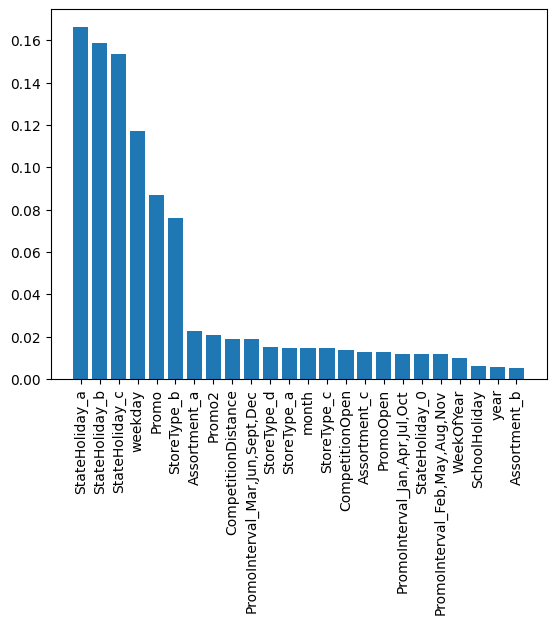

In [83]:
# 특성중요도 파악
plt.bar(imp_df['var'],
        imp_df['imp'])
plt.xticks(rotation=90)
plt.show()

In [71]:
score_list=[]
selected_varnum=[]

In [72]:
for i in range(1,25):
    selected_var = imp_df['var'].iloc[:i].to_list()
    scores = cross_val_score(xgb,
                             train[selected_var],
                             train['Sales'],
                             scoring="neg_mean_squared_error", cv=3)
    score_list.append(-np.mean(scores))
    selected_varnum.append(i)
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


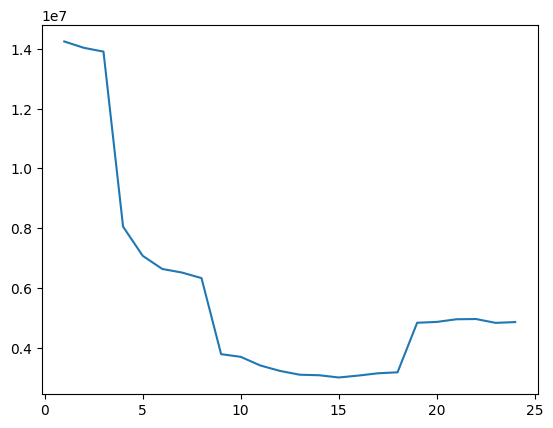

In [73]:
plt.plot(selected_varnum, score_list)

In [74]:
input_var = imp_df['var'].iloc[:17].tolist()
xgb.fit(train[input_var],
        train['Sales'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=2020, ...)

In [75]:
cross_val_score(xgb, train[input_var], train['Sales'], scoring="neg_mean_squared_error", cv=3)

array([-3424954.03701548, -3012967.95420961, -2990961.97872594])

In [76]:
estim_list = [100,200,300,400,500,600,700,800,900]
score_list = []

In [77]:
for i in estim_list:
    xgb = XGBRegressor( n_estimators=i, learning_rate= 0.1, random_state=2020)
    scores = cross_val_score(xgb, train[input_var], train['Sales'], scoring="neg_mean_squared_error", cv=3)
    score_list.append(-np.mean(scores))
    print(i)

100
200
300
400
500
600
700
800
900


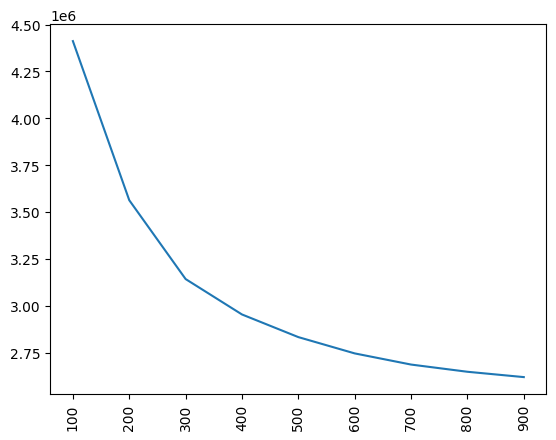

In [78]:
plt.plot(estim_list,score_list)
plt.xticks(rotation=90)
plt.show()

In [79]:
xgb = XGBRegressor( n_estimators=400, learning_rate= 0.1, random_state=2020)

In [80]:
xgb.fit(train[input_var],
        train['Sales'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=2020, ...)

In [81]:
cross_val_score(xgb, train[input_var], train['Sales'], scoring="neg_mean_squared_error", cv=3)

array([-3276044.3467525 , -2800629.4076923 , -2785711.35661683])